In [38]:
!pip install aiofiles


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [97]:
%load_ext autoreload
%autoreload 2

import re
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from np2_query.api import Env, Query
import np2_data_processing as np
import numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Query datetime for Vulcan and NRR sessions

In [98]:
start_date = "2023-06-01 00:00:00"
end_date = "2023-06-05 17:00:00"

start_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")


## Pull relevant NRR and PVT Tool sessions

In [99]:

def get_time_from_nrr_df(nrr_df):
    epoch_time = int(int(nrr_df['phoneTime'].iloc[0])/1000)
    utc_dt = datetime.fromtimestamp(epoch_time)
    return utc_dt
    
def get_nrr_info(nrr_json):
    # example: NRR/Tue-Vu/NRR-v1-20230509120357-kss(3).csv
    filename = nrr_json['filename']
    match = re.search(r'NRR/(.+)/NRR-v(\d+)-(\d+)-kss\((\d)\).csv', filename)
    if match:
        return match.group(1), match.group(2), match.group(3), match.group(4)
    else:
        return None
    

# Pull NRR
nrr_infos = []

def get_meta_property(nrr_json, index, prop):
    addprop = f'additionalProp{index}'
    if addprop in nrr_json['meta'] and prop in nrr_json['meta'][addprop]:
        return nrr_json['meta'][addprop][prop]
    else:
        return None

async with Query(Env.PRODUCTION) as api:
    nrr_jsons = await api.search_session_files(fileType = 'NRR')
    for nrr_json in nrr_jsons:
        
        if not re.match(r'sessions-NRR-uid\d+', nrr_json['sessionId']):
            # These are the original NRR extra session file uploads that we are interested.
            # When I posted the extra sessions to their corresponding vulcan sessions, I also used type NRR,
            # so we don't watch to double match those ones.
            continue
        
        # skip obvious test data or bad data
        file_size = int(nrr_json['fileSizeBytes'])
        if file_size < 3500:
            continue
            
        nrr_info = get_nrr_info(nrr_json)
        
        # if filename regex fails, regect (early test data that we don't want)
        if nrr_info is None:
            continue
        
        subject, version, nrr_datetime, kss = nrr_info
        subject = subject.lower()
        
        extra_session_file_id = nrr_json['id']
        nrr_df = await api.download_session_file_df(extra_session_file_id)
        
        if nrr_df is None or nrr_df.empty:
            continue

        version = get_meta_property(nrr_json, 1, 'NRR.V')
        # email only avilable for app version > 2
        email = get_meta_property(nrr_json, 2, 'email')
        if email is not None:
            email = email.lower()
        
        if version is not None:
            # for example: 20230511200356
            nrr_datetime = datetime.strptime(nrr_datetime, "%Y%m%d%H%M%S")
            nrr_datetime = nrr_datetime - timedelta(hours=1)
        else:
            # if previous version, use phoneTime since time from the filename is not correct
            nrr_datetime = get_time_from_nrr_df(nrr_df)
            version = '1'
            
        nrr_datetime = nrr_datetime - timedelta(hours=4)

        # If datetime out of range, don't use
        if nrr_datetime > end_date:
            #print(f"Leaving out nrr session ({subject}) due to time out of range (utc): {nrr_datetime.replace(tzinfo=None)}")
            continue
            
        if nrr_datetime < start_date:
            #print(f"Leaving out nrr session ({subject}) due to time out of range (utc): {nrr_datetime.replace(tzinfo=None)}")
            continue
            
        # conventient nrr object, add to list of found nrr sessions
        nrr_info = {
            'subject': subject,
            'email': email,
            'datetime': nrr_datetime,
            'version': version,
            'filename': nrr_json['filename'],
            'kss': kss,
            'nrr_df': nrr_df,
            'file_size': file_size,
            'matched': False,
        }
        nrr_infos.append(nrr_info)
            
# 176
nrr_infos.sort(key = lambda nrr_info: nrr_info['subject'], reverse=True)
print(f"Found {len(nrr_infos)} relevant NRR sessions:")

# Make folder nrr_sessions
os.makedirs('nrr_sessions', exist_ok=True)

# Show all infos in nrr_infos
for nrr_info in nrr_infos:
    print(f"Subject: {nrr_info['subject']}, DateTime: {nrr_info['datetime'].strftime('%Y-%m-%d %H:%M:%S')}")
    filename = f"{nrr_info['subject']}_{nrr_info['datetime'].strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    nrr_info['nrr_df'].to_csv(f'nrr_sessions/{filename}')
    
pvt_tool_folder_path = "pvt_tool_sessions"
pvt_tool_files = os.listdir(pvt_tool_folder_path)

pvt_tool_sessions = []

for file in pvt_tool_files:
    if file.endswith(".csv"):
        parts = file.split("_")
        subject = parts[0].split('-')
        subject = [name[0].lower() + name[1:].lower() for name in subject if not name.isdigit()]
        subject = '-'.join(subject)
        datetime_str = parts[1] + "_" + parts[2]
        datetime_obj = datetime.strptime(datetime_str, "%d-%m-%Y_%H-%M-%S") 

        with open(os.path.join(pvt_tool_folder_path, file), 'r') as f:
            reader = csv.reader(f)
            data = list(reader)
            
        pvt_tool_session = {
            'subject': subject,
            'datetime': datetime_obj,
            'data': data,
            'matched': False
        }
        pvt_tool_sessions.append(pvt_tool_session)
        
pvt_tool_sessions.sort(key = lambda pvt_tool_session: pvt_tool_session['subject'], reverse=True)
print()
print(f"All {len(pvt_tool_sessions)} PVT tool sessions:")

# Show all pvt tool sessions
for pvt_tool_session in pvt_tool_sessions:
    print(f"Subject: {pvt_tool_session['subject']}, DateTime: {pvt_tool_session['datetime'].strftime('%Y-%m-%d %H:%M:%S')}")
    

Found 61 relevant NRR sessions:
Subject: tue-vu, DateTime: 2023-06-01 10:04:22
Subject: tue-vu, DateTime: 2023-06-02 08:25:59
Subject: tue-vu, DateTime: 2023-06-02 13:24:44
Subject: tue-vu, DateTime: 2023-06-04 22:28:32
Subject: tue-vu, DateTime: 2023-06-05 08:57:10
Subject: tue-vu, DateTime: 2023-06-01 15:30:56
Subject: tristan-mclaurin, DateTime: 2023-06-04 14:06:44
Subject: tristan-mclaurin, DateTime: 2023-06-04 06:31:06
Subject: tristan-mclaurin, DateTime: 2023-06-05 05:55:36
Subject: tristan-mclaurin, DateTime: 2023-06-04 17:52:12
Subject: tristan-mclaurin, DateTime: 2023-06-02 13:40:16
Subject: tristan-mclaurin, DateTime: 2023-06-03 21:31:48
Subject: tristan-mclaurin, DateTime: 2023-06-04 22:02:47
Subject: tristan-mclaurin, DateTime: 2023-06-04 19:51:22
Subject: tristan-mclaurin, DateTime: 2023-06-05 08:37:24
Subject: tristan-mclaurin, DateTime: 2023-06-02 23:11:48
Subject: tristan-mclaurin, DateTime: 2023-06-03 23:33:56
Subject: tristan-mclaurin, DateTime: 2023-06-03 17:45:03
Su

## Match NRR and PVT Tool sessions based on name/datetime

In [100]:
matched_pairs = []
    
for nrr_info in nrr_infos:
    for pvt_tool_session in pvt_tool_sessions:
        if nrr_info['subject'] == pvt_tool_session['subject'] or (nrr_info['subject'] == "michael-kasparian" and pvt_tool_session['subject'] == "mike-kasparian"):
            time_diff = abs(nrr_info['datetime'] - pvt_tool_session['datetime'])
            if time_diff <= timedelta(minutes=10):
                nrr_info['matched'] = True
                pvt_tool_session['matched'] = True
                matched_pairs.append((nrr_info, pvt_tool_session))

print()
print(f"Found {len(matched_pairs)} Matched Pairs:")

os.makedirs('pvt_tool_nrr_sessions', exist_ok=True)
                
for pair in matched_pairs:
    nrr_info, pvt_tool_session = pair
    
    print(f"NRR - Subject: {nrr_info['subject']}, DateTime: {nrr_info['datetime'].strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"PVT - Subject: {pvt_tool_session['subject']}, DateTime: {pvt_tool_session['datetime'].strftime('%Y-%m-%d %H:%M:%S')}")
    
    avg_datetime = nrr_info['datetime'] + (pvt_tool_session['datetime'] - nrr_info['datetime']) / 2
    avg_datetime_str = avg_datetime.strftime('%Y-%m-%d_%H-%M-%S')
    
    # Create a directory for the pair
    pair_dir = f"{nrr_info['subject']}_{avg_datetime_str}"
    pair_dir_path = os.path.join('pvt_tool_nrr_sessions', pair_dir)
    os.makedirs(pair_dir_path, exist_ok=True)
    
    # Save nrr info to csv
    nrr_filename = f"{nrr_info['subject']}_NRR_{nrr_info['datetime'].strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    nrr_filepath = os.path.join(pair_dir_path, nrr_filename)
    nrr_info['nrr_df'].to_csv(nrr_filepath, index=False)
    
    # Save pvt tool session data to csv
    pvt_filename = f"{pvt_tool_session['subject']}_PVT_{pvt_tool_session['datetime'].strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    pvt_filepath = os.path.join(pair_dir_path, pvt_filename)
    pvt_tool_session['data'] =  pd.DataFrame(pvt_tool_session['data'])
    pvt_tool_session['data'].to_csv(pvt_filepath, index=False)
    
    print()


Found 59 Matched Pairs:
NRR - Subject: tue-vu, DateTime: 2023-06-01 10:04:22
PVT - Subject: tue-vu, DateTime: 2023-06-01 10:07:31

NRR - Subject: tue-vu, DateTime: 2023-06-02 08:25:59
PVT - Subject: tue-vu, DateTime: 2023-06-02 08:22:46

NRR - Subject: tue-vu, DateTime: 2023-06-02 13:24:44
PVT - Subject: tue-vu, DateTime: 2023-06-02 13:27:51

NRR - Subject: tue-vu, DateTime: 2023-06-04 22:28:32
PVT - Subject: tue-vu, DateTime: 2023-06-04 22:25:18

NRR - Subject: tue-vu, DateTime: 2023-06-05 08:57:10
PVT - Subject: tue-vu, DateTime: 2023-06-05 09:00:19

NRR - Subject: tue-vu, DateTime: 2023-06-01 15:30:56
PVT - Subject: tue-vu, DateTime: 2023-06-01 15:27:38

NRR - Subject: tristan-mclaurin, DateTime: 2023-06-04 14:06:44
PVT - Subject: tristan-mclaurin, DateTime: 2023-06-04 14:09:58

NRR - Subject: tristan-mclaurin, DateTime: 2023-06-04 06:31:06
PVT - Subject: tristan-mclaurin, DateTime: 2023-06-04 06:26:49

NRR - Subject: tristan-mclaurin, DateTime: 2023-06-05 05:55:36
PVT - Subject: t

## Calculate PVT Performance from NRR and PVT Tool Sesions

In [101]:
def get_num_lapses(df):
    value_counts = df[5].value_counts()
    num_lapses = value_counts.get(3, 0)
    return num_lapses

def get_num_false_starts(df):
    value_counts = df[5].value_counts()
    false_starts = value_counts.get(1, 0)
    return false_starts

def get_tot_trials(df):
    df_sub = df.iloc[2:, 1] # Select the second column starting from the second row
    df_sub = pd.to_numeric(df_sub, errors='coerce') # Convert to numbers, turn errors into NaN
    df_sub = df_sub.dropna() # Drop missing values
    df_sub = df_sub.astype(int) # Now safe to convert to integers
    max_trial = df_sub.max() # Find the maximum value
    return max_trial

def calc_performance(df):
    lapses = get_num_lapses(df)
    false_starts = get_num_false_starts(df)
    tot_trials = get_tot_trials(df)
    
    num = (lapses + false_starts)
    right_side = (num / tot_trials)
    performance = (1 - right_side)
    
    return performance

folder_name = 'pvt_tool_nrr_comparison'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

nrr_performances = []
pvt_tool_performances = []

print(f"All {len(matched_pairs)} matched performances scores:")
    
for pair in matched_pairs:
    nrr_info, pvt_tool_session = pair
    
    # NRR
    nrr_dataframe = nrr_info['nrr_df']
    PVT = np.PVT(nrr_dataframe)
    nrr_performance = PVT.get_performance()
    print(f"NRR - Subject: {nrr_info['subject']}, Performance: {nrr_performance}")
    nrr_performances.append(nrr_performance)
    
    # PVT
    pvt_tool_dataframe = pvt_tool_session['data']
    pvt_tool_performance = calc_performance(pvt_tool_dataframe)
    print(f"PVT - Subject: {pvt_tool_session['subject']}, Performance: {pvt_tool_performance}")
    pvt_tool_performances.append(pvt_tool_performance)
    
    avg_datetime = nrr_info['datetime'] + (pvt_tool_session['datetime'] - nrr_info['datetime']) / 2
    avg_datetime_str = avg_datetime.strftime('%Y-%m-%d_%H-%M-%S')

    csv_file_name = f"{nrr_info['subject']}_{avg_datetime_str}.csv"
    csv_file_path = os.path.join(folder_name, csv_file_name)

    data = {
        'Subject': ["NRR: " + nrr_info['subject'], "PVT: " + pvt_tool_session['subject']],
        'Datetime': [nrr_info['datetime'], pvt_tool_session['datetime']],
        'Performance': [nrr_performance, pvt_tool_performance]
    }
    df = pd.DataFrame(data)

    df.to_csv(csv_file_path, index=False)

    print()
    

All 59 matched performances scores:
NRR - Subject: tue-vu, Performance: 0.9318181818181819
PVT - Subject: tue-vu, Performance: 0.9189189189189189

NRR - Subject: tue-vu, Performance: 0.8260869565217391
PVT - Subject: tue-vu, Performance: 0.9487179487179487

NRR - Subject: tue-vu, Performance: 0.8780487804878049
PVT - Subject: tue-vu, Performance: 0.9473684210526316

NRR - Subject: tue-vu, Performance: 0.7567567567567568
PVT - Subject: tue-vu, Performance: 0.9736842105263158

NRR - Subject: tue-vu, Performance: 0.9512195121951219
PVT - Subject: tue-vu, Performance: 0.9230769230769231

NRR - Subject: tue-vu, Performance: 0.8604651162790697
PVT - Subject: tue-vu, Performance: 0.9743589743589743

NRR - Subject: tristan-mclaurin, Performance: 0.9761904761904762
PVT - Subject: tristan-mclaurin, Performance: 0.6842105263157895

NRR - Subject: tristan-mclaurin, Performance: 0.875
PVT - Subject: tristan-mclaurin, Performance: 0.6666666666666667

NRR - Subject: tristan-mclaurin, Performance: 0.9

## Create Scatterplot and Calculate Correlation

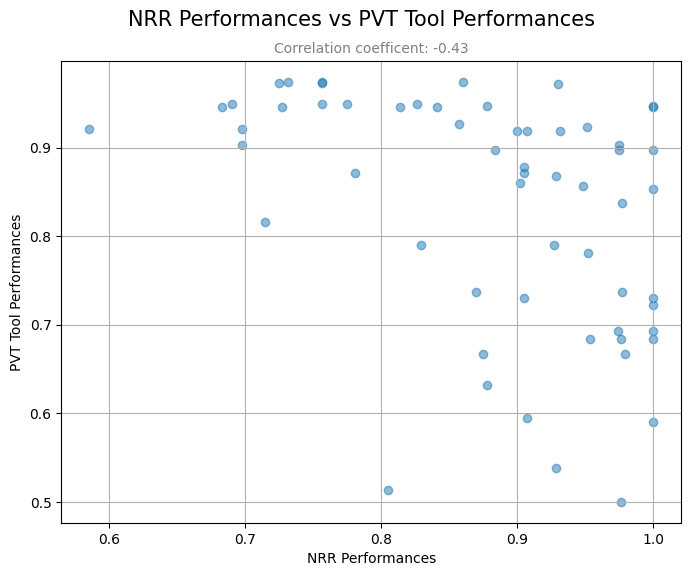

In [125]:
plt.figure(figsize=(8, 6))
plt.scatter(nrr_performances, pvt_tool_performances, alpha=0.5)

correlation_matrix = numpy.corrcoef(nrr_performances, pvt_tool_performances)
correlation = correlation_matrix[0, 1]

plt.suptitle('NRR Performances vs PVT Tool Performances', y=0.965, fontsize=15)
plt.title(f'Correlation coefficent: {correlation:.2f}', fontsize=10, color='gray')
plt.xlabel('NRR Performances')
plt.ylabel('PVT Tool Performances')
plt.grid(True)

# Create the folder if it doesn't exist
folder_path = 'pvt_tool_nrr_comparison_graphs'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the graph
save_file = os.path.join(folder_path, 'nrr_vs_pvt_tool_performances.png')
plt.savefig(save_file, bbox_inches='tight')

plt.show()

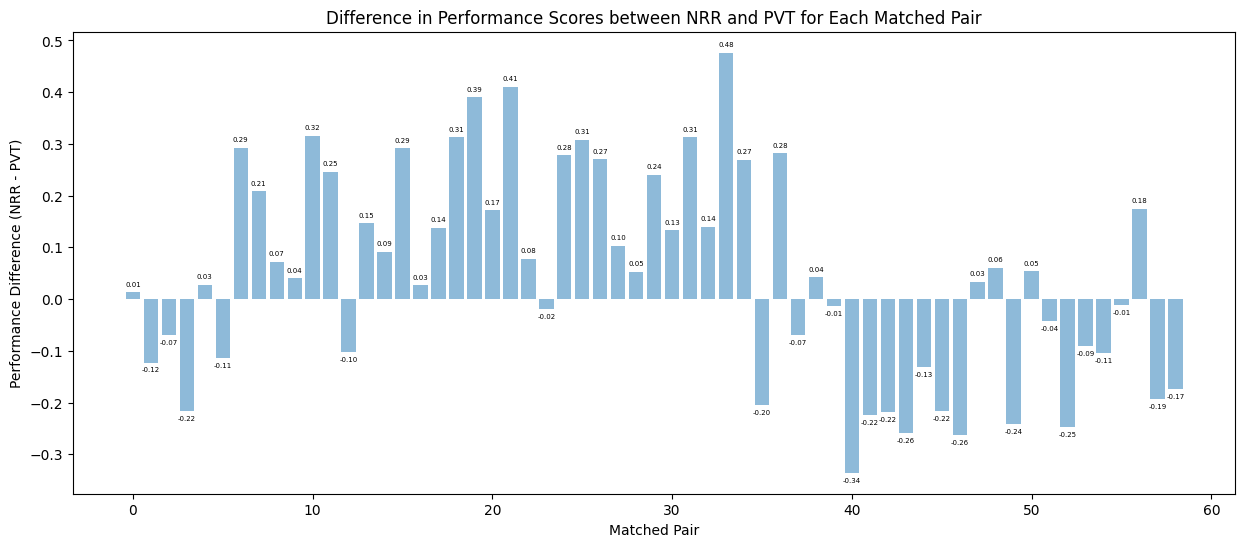

In [124]:
differences = numpy.array(nrr_performances) - numpy.array(pvt_tool_performances)
x_pos = numpy.arange(len(differences))
plt.figure(figsize=(15, 6))
bars = plt.bar(x_pos, differences, align='center', alpha=0.5)

for bar, diff in zip(bars, differences):
    height = bar.get_height()
    if height >= 0:
        label_position = height + 0.01
    else:
        label_position = height - 0.02
    plt.text(bar.get_x() + bar.get_width() / 2, label_position,
             f'{diff:.2f}', ha='center', va='bottom', fontsize=5)

plt.xlabel('Matched Pair')
plt.ylabel('Performance Difference (NRR - PVT)')
plt.title('Difference in Performance Scores between NRR and PVT for Each Matched Pair')

# Create the folder if it doesn't exist
folder_path = 'pvt_tool_nrr_comparison_graphs'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the graph
save_file = os.path.join(folder_path, 'differences_in_performance_scores.png')
plt.savefig(save_file, bbox_inches='tight')

plt.show()